# EuroPython 2021: Drift Detection with `alibi-detect`

In this notebook we demonstrate how drift detection can be performed in an online manner on a medical imaging problem of real practical interest.

In [1]:
from typing import Tuple, Generator, Callable, Optional
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from wilds.common.data_loaders import get_train_loader
from wilds import get_dataset

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

## Data

We will use the Camelyon17 medical imaging dataset, one of the [WILDS](https://wilds.stanford.edu/) datasets of Koh et al. (2020) that represent "in-the-wild" distribution shifts for various data modalities. It contains tissue scans to be classificatied as benign or cancerous. The pre-change distribution corresponds to a mixture of scans from across three hospitals and the post-change distribution corresponds to scans from a new fourth hospital.

Koh et al. (2020) show that models trained on scans from the pre-change distribution achieve an accuracy of 93.2% on unseen scans from same distribution, but only 70.3% accuracy on scans from the post-change distribution.

<br>

<div>
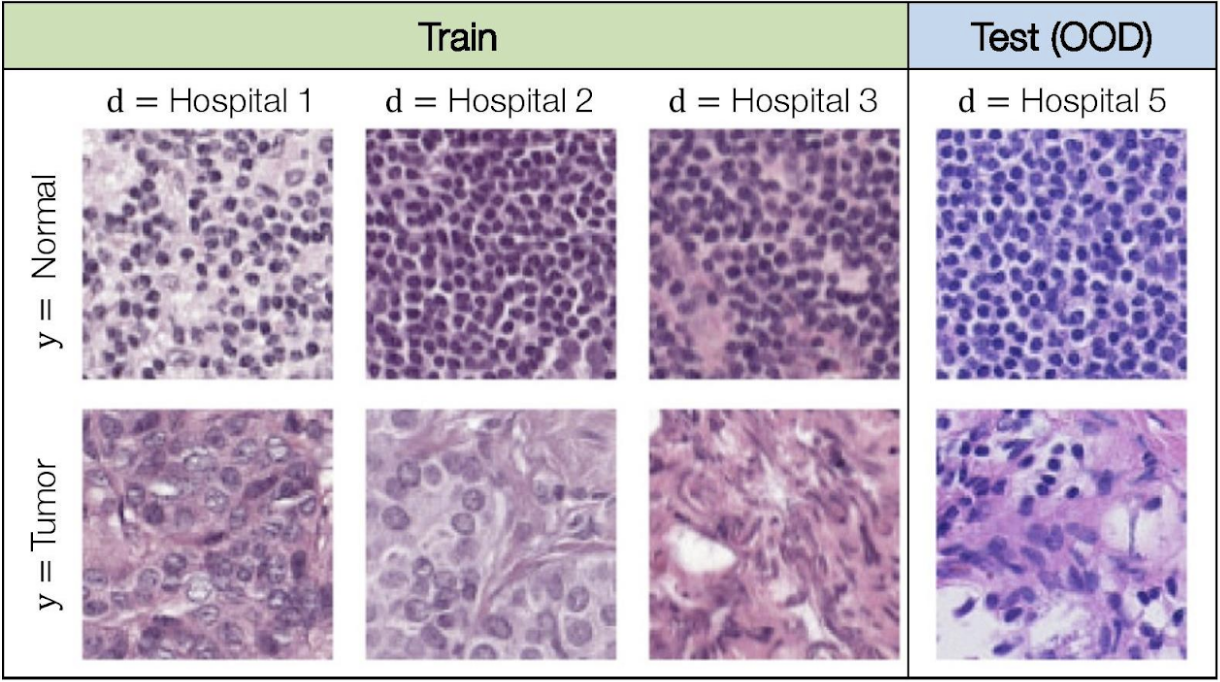
</div>

In [2]:
WILDS_PATH = '/home/data/wilds'  # where you'd like to save/load data to/from (11 GB)
DOWNLOAD = False  # set to True for first run
N = 2500  # size of reference set

We use the `wilds` library to load and resize the data but define our own function that converts the various splits of data into streams in order to simulate a live deployment environment.

In [3]:
def stream_camelyon(
    split: str='train', 
    img_size: Tuple[int]=(96,96), 
    root_dir: str=None, 
    download: bool=False
) -> Generator:

    camelyon = get_dataset('camelyon17', root_dir=root_dir, download=download)
    ds = camelyon.get_subset(
        split, 
        transform=transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
    )
    ds_iter = iter(get_train_loader('standard', ds, batch_size=1))

    while True:
        try:
            img = next(ds_iter)[0][0]
        except Exception:
            ds_iter = iter(get_train_loader('standard', ds, batch_size=1))
            img = next(ds_iter)[0][0]
        yield img.numpy()

We simulate a single reference set of size $N$ from the training distribution and define two streams of data: one with the same underlying distribution as the training data (no change) and one with a slightly different distribution (change) corresponding to the previously unseen fourth hospital. 

By looking at the average run time of a detector on the unchanged stream we can get an idea of the frequency of false alarms and by looking at the average run time on the changed stream we can get an idea of how quickly the detector is able to identify change when it occurs

In [4]:
stream_train = stream_camelyon(split='train', root_dir=WILDS_PATH, download=DOWNLOAD)
x_ref = np.stack([next(stream_train) for _ in range(N)], axis=0)

stream_unchanged = stream_camelyon(split='id_val', root_dir=WILDS_PATH, download=DOWNLOAD)
stream_changed = stream_camelyon(split='test', root_dir=WILDS_PATH, download=DOWNLOAD)

Shown below are samples from the unchanged stream:

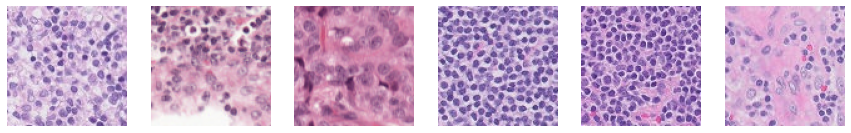

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15,4))
for i in range(6):
    axs[i].imshow(np.transpose(next(stream_unchanged), (1,2,0)))
    axs[i].axis('off')

And samples from the changed stream:

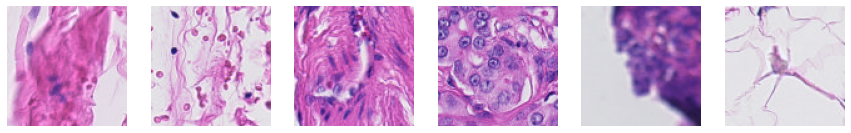

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15,4))
for i in range(6):
    axs[i].imshow(np.transpose(next(stream_changed), (1,2,0)))
    axs[i].axis('off')

## Drift Detection

We will adopt the strategy of overlapping windows and use as the test statistic an estimator of Maximum Mean Discrepancy $MMD_k$ that can be updated incrementally.

### Kernel

Rather than apply a simple kernel directly to the high dimensional (96x96x3) scans we will define a more meaningful kernel by projecting onto a more structured lower dimensional space before applying a simple (Gaussian) kernel. We learn the structured representation by training a convolutional autoencoder and then using the encoder. It is important that trained preprocessing components are trained on a split of data that doesn't then form part of the reference data passed to the drift detector.

In [7]:
ENC_DIM = 32
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-3

In [8]:
encoder = nn.Sequential(
    nn.Conv2d(3, 8, 5, stride=3, padding=1),    # [batch, 8, 32, 32]
    nn.ReLU(),
    nn.Conv2d(8, 12, 4, stride=2, padding=1),   # [batch, 12, 16, 16]
    nn.ReLU(),
    nn.Conv2d(12, 16, 4, stride=2, padding=1),   # [batch, 16, 8, 8]
    nn.ReLU(),
    nn.Conv2d(16, 20, 4, stride=2, padding=1),   # [batch, 20, 4, 4]
    nn.ReLU(),
    nn.Conv2d(20, ENC_DIM, 4, stride=1, padding=0),   # [batch, enc_dim, 1, 1]
    nn.Flatten(), 
)
decoder = nn.Sequential(
    nn.Unflatten(1, (ENC_DIM, 1, 1)),
    nn.ConvTranspose2d(ENC_DIM, 20, 4, stride=1, padding=0),  # [batch, 20, 4, 4]
    nn.ReLU(),
    nn.ConvTranspose2d(20, 16, 4, stride=2, padding=1),  # [batch, 16, 8, 8]
    nn.ReLU(),
    nn.ConvTranspose2d(16, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
    nn.ReLU(),
    nn.ConvTranspose2d(12, 8, 4, stride=2, padding=1),  # [batch, 8, 32, 32]
    nn.ReLU(),
    nn.ConvTranspose2d(8, 3, 5, stride=3, padding=1),   # [batch, 3, 96, 96]
    nn.Sigmoid(),
)
ae = nn.Sequential(encoder, decoder).to(device)

x_fit, x_ref = np.split(x_ref, [len(x_ref)//2])
x_fit = torch.as_tensor(x_fit)
x_fit_dl = DataLoader(TensorDataset(x_fit, x_fit), BATCH_SIZE, shuffle=True)

We can train the autoencoder using a helper function provided for convenience in `alibi-detect`.

In [9]:
from alibi_detect.models.pytorch import trainer

trainer(ae, nn.MSELoss(), x_fit_dl, device, learning_rate=LEARNING_RATE, epochs=EPOCHS)

2021-07-29 17:38:50.871959: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 134.71it/s, loss=0.0205]


The preprocessing/projection functions are expected to map numpy arrays to numpy arrays, so we wrap the encoder within the function below.

In [10]:
def encoder_fn(x: np.ndarray) -> np.ndarray:
    x = torch.as_tensor(x).to(device)
    with torch.no_grad():
        x_proj = encoder(x)
    return x_proj.cpu().numpy()

### Defining the detector

Defining the detector is as simple as importing the desired detector from `alibi_detect` and passing the reference data, desired ERT, and window size. The thresholds are configured via simulation in an initial configuration phase. The thresholds vary for the first few time-steps to account for correlation between consecutive test statistics.

In [11]:
ERT = 150  # expected run-time in absence of change
W = 20  # size of test window
B = 100_000  # number of simulations to configure threshold

In [12]:
from alibi_detect.cd import MMDDriftOnline

dd = MMDDriftOnline(x_ref, ERT, W, backend='pytorch', preprocess_fn=encoder_fn)

Generating permutations of kernel matrix..


Computing thresholds: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.98it/s]


### Applying the detector

The detector can then be used by passing instances from the stream to the detector's `.predict()` method one at a time. The `.predict()` method returns a dictionary of useful information, most notably whether it believes drift has occured. We iterate through the stream inside the `compute_runtime` function which takes the detector and a stream as arguments and returns the time step at which the detector flags drift on that stream.

In [13]:
def compute_runtime(detector: Callable, stream: Generator) -> int:
    
    detector.reset()
    detected = False
    
    while not detected:
        z = next(stream)
        pred = detector.predict(z)
        detected = pred['data']['is_drift']
        
    print(detector.t)
    return detector.t

We see that on the unchanged stream the detector achieves runtimes that are on average close to the ERT. The runtimes listed below correspond to a single set of calibrated thresholds, however if we averaged runtimes over a large number of calibrations then we would see the desired ERT is being targeted.

In [14]:
times_h0 = [compute_runtime(dd, stream_unchanged) for i in range(15)]
print(f"Average runtime in absence of change: {np.array(times_h0).mean()}")

14
15
156
324
50
15
21
213
160
33
5
462
107
95
163
Average runtime in absence of change: 122.2


We may look under the hood at the trajectory of the test statistic and see how it ended up crossing the threshold by looking at the `.test_stats` and `.thresholds` properties. We see here that the threshold was eventually crossed at time 163 (this corresponds to the final time shown above).

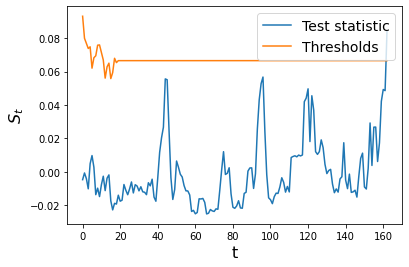

In [15]:
ts = np.arange(dd.t)
plt.plot(ts, dd.test_stats, label='Test statistic')
plt.plot(ts, dd.thresholds, label='Thresholds')
plt.xlabel('t', fontsize=16)
plt.ylabel('$S_t$', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.show()

We now see that when applied to the changed stream the detector is much quicker to make detections, as should any good drift detector.

In [16]:
times_h1 = [compute_runtime(dd, stream_changed) for i in range(15)]
print(f"Average runtime in the presence change: {np.array(times_h1).mean()}")

18
10
23
12
21
15
9
19
4
21
18
12
23
2
9
Average runtime in the presence change: 14.4


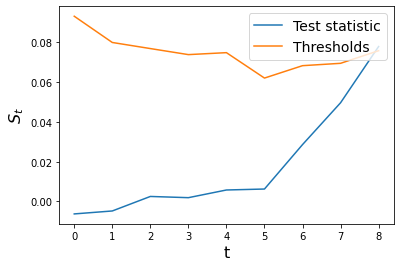

In [17]:
ts = np.arange(dd.t)
plt.plot(ts, dd.test_stats, label='Test statistic')
plt.plot(ts, dd.thresholds, label='Thresholds')
plt.xlabel('t', fontsize=16)
plt.ylabel('$S_t$', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.show()